In [1]:
import os
import torch
import tqdm
import rasterio
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
from typing import Type
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from pkgs import dataprepare
from pkgs import legacytraining
from pkgs import neuralnet


In [ ]:
class UrbanGreenSegmentation(pl.LightningModule):
    def __init__(self, rotate_training_data : bool = False, train_ratio : float = 0.8, patch_size : int = 100, batch_size : int = 4, region:str = 'N12'):
        super(UrbanGreenSegmentation, self).__init__()
        raw_data_array, OHE_target_array, raw_target_array = dataprepare.prepare_raw_files(region)
        self.batch_size = batch_size
        self.Datasets = {
            'Train' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio),
            'Validation' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio),
            'Prediction' : dataprepare.TrainDataset3(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
        }

        self.Dataloaders = {
            'Train' : DataLoader(self.Datasets['Train'], batch_size=batch_size),
            'Validation' : DataLoader(self.Datasets['Validation'], batch_size=batch_size),
            'Prediction' : DataLoader(self.Datasets['Prediction'], batch_size=batch_size)
        }
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet()
        self.regression = neuralnet.Splitted_Regression()
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=7)
        self.bn1 = nn.BatchNorm2d(7)
        self.bn2 = nn.BatchNorm2d(14)
        self.fc2 = nn.Conv2d(in_channels=14, out_channels=7)
        self.softmax = nn.Softmax2d()

    def forward(self, x_seg, x_reg):
        x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        x_seg = torch.cat((x_reg, x_seg), dim=1)
        x_seg = self.bn2(x_seg)
        x_seg = self.fc2(x_seg)
        x_seg = self.softmax(x_seg)
        return x_seg


    def training_step(self, batch, batch_idx):
        x_seg, x_reg, y_seg, _ = batch
        y_hat = self(x_seg, x_reg)
        return {'loss' : F.cross_entropy(y_hat, y_seg)}

    def validation_step(self, batch, batch_idx):
        x_seg, x_reg, y_seg, _ = batch
        y_hat = self(x_seg, x_reg)
        return {
            'valid_loss' : F.cross_entropy(y_hat, y_seg),
            'y_hat' : y_hat.detach(),
            'y' : y_seg.detach()
        }

    def predict_step(self, batch, batch_idx):
        pass

    def configure_optimizers(self):
        train_optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(train_optimizer, T_max=10)
        return [train_optimizer], [train_scheduler]

    def train_dataloader(self):
        return DataLoader(self.Datasets['Train'], batch_size = self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.Datasets['Validation'], batch_size = self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.Datasets['Prediction'], batch_size = self.batch_size)

In [ ]:
class UrbanGreenSegmentation(nn.Module):
    def __init__(self, device = 'cuda:0'):
        super(UrbanGreenSegmentation, self).__init__()
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet()
        self.regression = neuralnet.Splitted_Regression(device=device)
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=7, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(7)
        self.bn2 = nn.BatchNorm2d(14)
        self.fc2 = nn.Conv2d(in_channels=14, out_channels=7, kernel_size=1)
        self.softmax = nn.Softmax2d()

    def forward(self, x_seg, x_reg):
        x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        x_seg = torch.cat((x_reg, x_seg), dim=1)
        x_seg = self.bn2(x_seg)
        x_seg = self.fc2(x_seg)
        x_seg = self.softmax(x_seg)
        return x_seg


In [2]:
class UrbanGreenSegmentation2(nn.Module):
    def __init__(self, in_channel:int=6, out_channel:int=7):
        super(UrbanGreenSegmentation2, self).__init__()
        
        # 3개 배치 사용시 메모리 5기가
        # 2개 배치 사용시 메모리 3.8기가

        self.unet = neuralnet.UNet(in_channel=in_channel)
        #self.regression = neuralnet.Splitted_Regression()
        
        self.fc1 = nn.Conv2d(in_channels=64, out_channels=out_channel, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        #self.bn2 = nn.BatchNorm2d(14)
        #self.fc2 = nn.Conv2d(in_channels=14, out_channels=7, kernel_size=1)


    def forward(self, x_seg):
        #x_reg = self.regression(x_reg)
        x_seg = self.unet(x_seg)
        x_seg = self.fc1(x_seg)
        x_seg = self.bn1(x_seg)
        #x_seg = torch.cat((x_reg, x_seg), dim=1)
        #x_seg = self.bn2(x_seg)
        #x_seg = self.fc2(x_seg)

        return x_seg


In [3]:
gpus = 0 # slot number (e.g., 3), no gpu use -> write just ' '
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=str(gpus)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 4
patch_size = 100
train_ratio = 0.8
rotate_training_data = True
categories = 5

In [4]:
raw_data_array_N12 ,raw_target_array_N12, OHE_target_array_N12 = dataprepare.prepare_raw_files('N12', categories=categories)
raw_data_array_H19 ,raw_target_array_H19, OHE_target_array_H19 = dataprepare.prepare_raw_files('H19', categories=categories)
raw_data_array_M18 ,raw_target_array_M18, OHE_target_array_M18 = dataprepare.prepare_raw_files('M18', categories=categories)

raw_data_array = np.concatenate((raw_data_array_N12, raw_data_array_H19, raw_data_array_M18), axis=-1)
raw_target_array = np.concatenate((raw_target_array_N12, raw_target_array_H19, raw_target_array_M18), axis=-1)
OHE_target_array = np.concatenate((OHE_target_array_N12, OHE_target_array_H19, OHE_target_array_M18), axis=-1)

No Data Found. Loading from Raw Data
Max of the array : 4.568826675415039
Max of the array : 4.9186177253723145
Max of the array : 4.57381534576416
Not fitting. Trimming Data.
(6, 2400, 2400)
No Data Found. Loading from Raw Data
Max of the array : 3.477010726928711
Max of the array : 3.7164974212646484
Max of the array : 3.5140061378479004
Not fitting. Trimming Data.
(6, 2400, 2400)
No Data Found. Loading from Raw Data
Max of the array : 3.887455701828003
Max of the array : 4.192636489868164
Max of the array : 3.8765461444854736
Not fitting. Trimming Data.
(6, 2400, 2400)


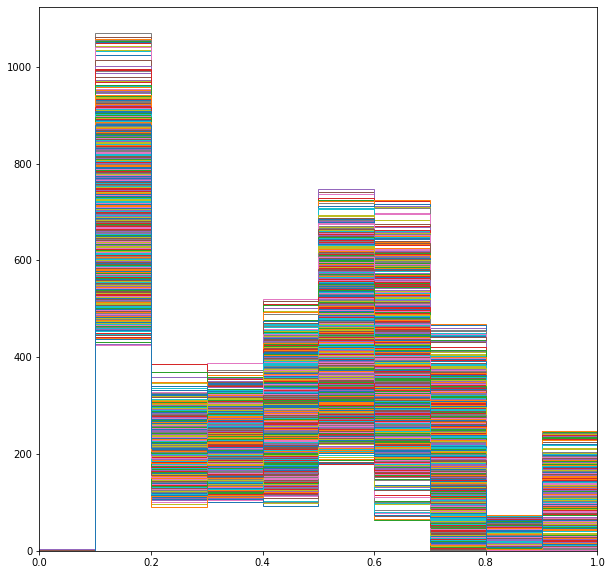

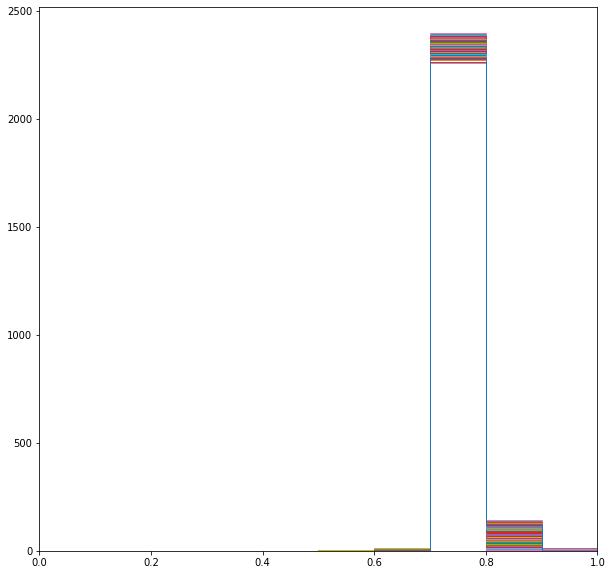

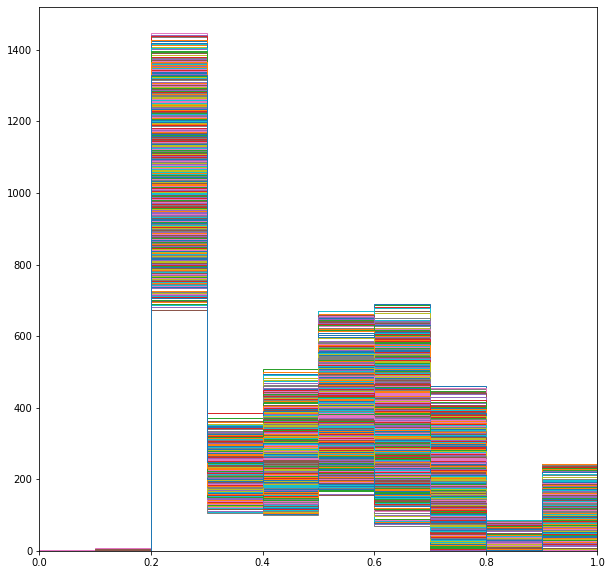

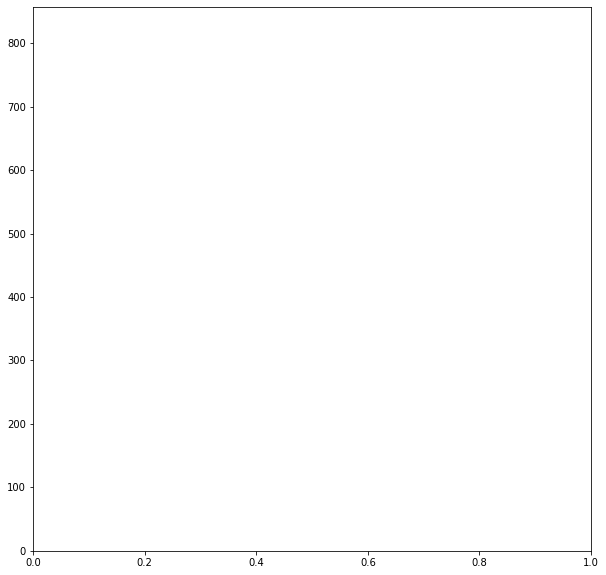

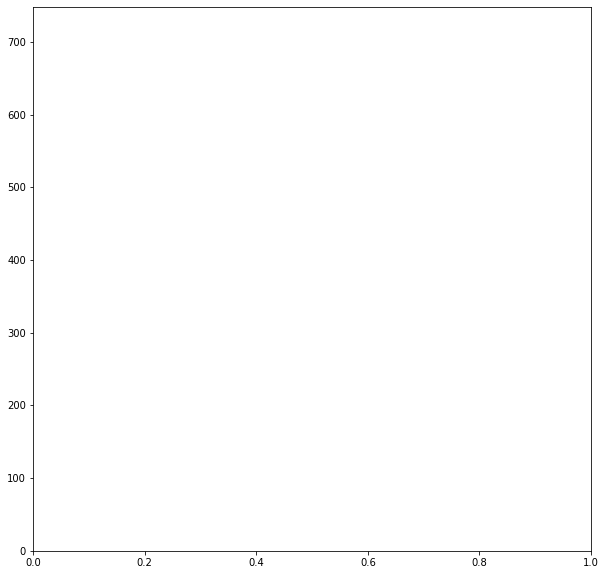

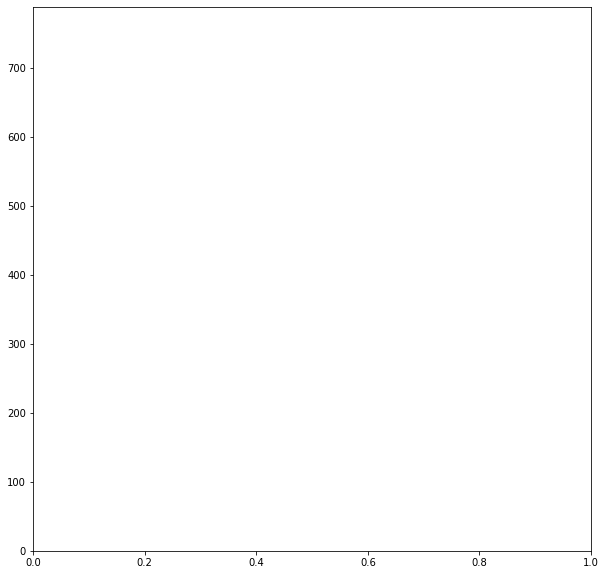

In [9]:
for i in range(raw_data_array_N12.shape[0]):
    region = 'M18'
    plt.figure(figsize=(10,10))
    plt.xlim((0,1))
    plt.hist(raw_data_array_M18[i,:,:], bins=10, histtype='step')
    plt.savefig(f'../Data/{region}/Train_Data_{i}_Histogram.png', dpi=300)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(raw_target_array[:,1200:3600])
print(raw_target_array.max())

In [ ]:
data = raw_target_array[:,0:2400]
for i in range(2):
    rotated_data = np.rot90(data, k=i+1, axes=(-2, -1))
    data = np.concatenate((data, rotated_data), axis=0)

In [ ]:
plt.figure(figsize = (64,16))
plt.imshow(data)

In [5]:
Datasets_ver3 = {
    'Train' : dataprepare.TrainDataset4(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, rotate = rotate_training_data, train_ratio = train_ratio, categories=categories),
    'Validation' : dataprepare.TrainDataset4(raw_data_array, OHE_target_array, raw_target_array, patch_size = patch_size, is_validating = True, rotate = rotate_training_data, train_ratio = train_ratio, categories=categories),
    'Prediction' : dataprepare.TrainDataset4(raw_data_array_H19, OHE_target_array_H19, raw_target_array_H19, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio, categories=categories)
}
Dataloaders_ver3 = {
    'Train' : DataLoader(Datasets_ver3['Train'], batch_size=batch_size),
    'Validation' : DataLoader(Datasets_ver3['Validation'], batch_size=batch_size),
    'Prediction' : DataLoader(Datasets_ver3['Prediction'], batch_size=2)
}
'''model = UrbanGreenSegmentation()
criterion3 = nn.CrossEntropyLoss()
optimizer3 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=5, factor=0.75)'''

100%|██████████| 6/6 [00:01<00:00,  4.99it/s]


Data shape: (6, 2400, 7200) | Target shape: (7, 2400, 7200)
Internal data array : (1728, 6, 100, 100)
Shape of label after 0 rotation : (3456, 100, 100)
Shape of label after 1 rotation : (6912, 100, 100)


100%|██████████| 6/6 [00:01<00:00,  4.98it/s]


Data shape: (6, 2400, 7200) | Target shape: (7, 2400, 7200)
Internal data array : (1728, 6, 100, 100)
Shape of label after 0 rotation : (3456, 100, 100)
Shape of label after 1 rotation : (6912, 100, 100)


100%|██████████| 6/6 [00:00<00:00, 14.17it/s]


Data shape: (6, 2400, 2400) | Target shape: (7, 2400, 2400)
Internal data array : (576, 6, 100, 100)


"model = UrbanGreenSegmentation()\ncriterion3 = nn.CrossEntropyLoss()\noptimizer3 = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)\nscheduler3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer3, 'min', patience=5, factor=0.75)"

In [6]:
a,_,b,_ = Dataloaders_ver3['Validation'].dataset[:]


tensor(0.9668)
tensor(4.)
tensor(4.)
tensor(1.)
tensor(4.)
tensor(4.)
tensor(4.)
tensor(1.)
tensor(4.)
tensor(4.)
tensor(4.)
tensor(4.)


"i = 0\nfor batch in Dataloaders_ver3['Train']:\n    data, _, target, _ = batch\n\n    if i < 10:\n        i+= 1\n    else:\n        break\n    plt.figure(figsize=(3,3))\n    plt.imshow(model2(target[0,:,:]).to('cpu', dtype=torch.int64))\n    plt.figure(figsize=(3,3))\n    plt.xlim((0,4))\n    plt.hist(target[0,:,:].to('cpu', dtype=torch.int64))"

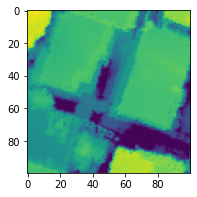

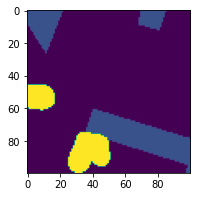

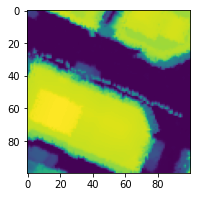

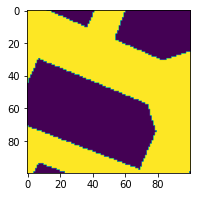

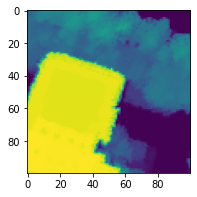

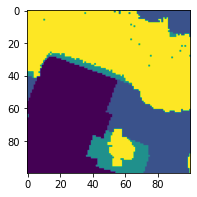

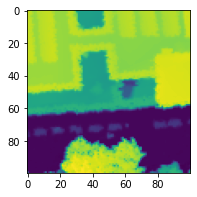

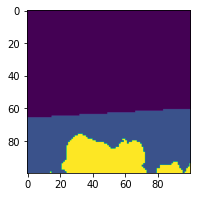

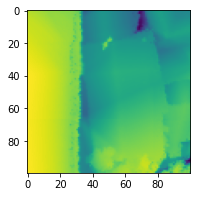

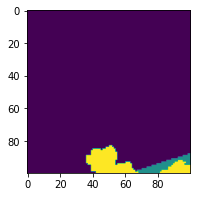

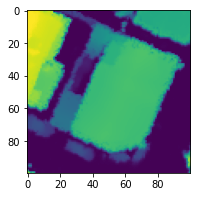

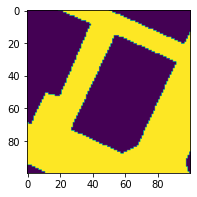

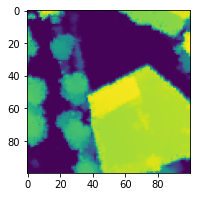

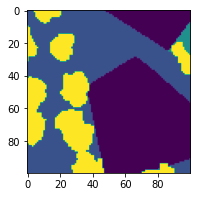

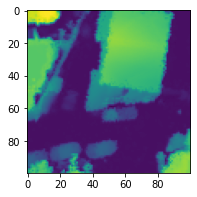

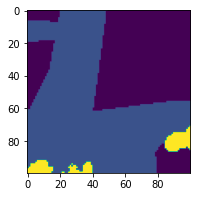

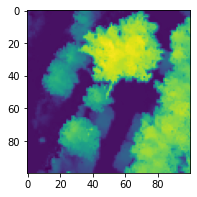

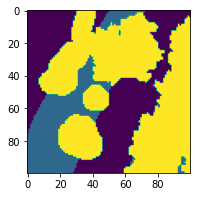

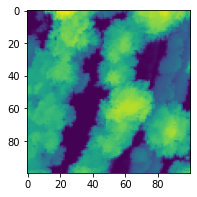

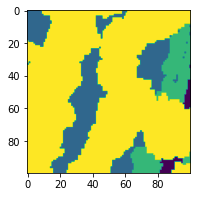

In [8]:
print(a.max())
print(b.max())
for i in range(10):
    j = np.random.randint(0, b.shape[0])
    plt.figure(figsize=(3,3))
    plt.imshow(a[j,0,92:192,92:192])
    plt.figure(figsize=(3,3))
    plt.imshow(b[j,:,:])
    print(b[j,:,:].max())
#plt.figure(figsize=(10,10))
#plt.imshow(raw_target_array[0:100, 100:200])
'''i = 0
for batch in Dataloaders_ver3['Train']:
    data, _, target, _ = batch

    if i < 10:
        i+= 1
    else:
        break
    plt.figure(figsize=(3,3))
    plt.imshow(model2(target[0,:,:]).to('cpu', dtype=torch.int64))
    plt.figure(figsize=(3,3))
    plt.xlim((0,4))
    plt.hist(target[0,:,:].to('cpu', dtype=torch.int64))'''
    #print(f'Max of data : {data.max()}')
    #print(f'Max of target : {target.max()}')

In [10]:

model2 = UrbanGreenSegmentation2(out_channel=categories)
model2 = nn.DataParallel(model2)
model2.load_state_dict(torch.load('/share/project/intern/Byeongchan/Data/Model/Segmentation/Categories_5/2022.8.19/normalization_activated/tmp_normalization_activated/17.pth'))
model2.to(device)
region = input("Enter Region") or 'N11'


In [11]:
raw_data_array_N11 ,raw_target_array_N11, OHE_target_array_N11 = dataprepare.prepare_raw_files(region, categories=categories)
patch_size = 100
N11_prediction_dataset = dataprepare.TrainDataset4(raw_data_array_N11, OHE_target_array_N11, raw_target_array_N11, patch_size = patch_size, is_evaluating = True, train_ratio = train_ratio)
N11_prediction_dataloader = DataLoader(N11_prediction_dataset, batch_size=2)
reference_data = f'/share/project/intern/Byeongchan/Data/{region}/{region}_lidar.tif'

No Data Found. Loading from Raw Data
Max of the array : 3.477010726928711
Max of the array : 3.7164974212646484
Max of the array : 3.5140061378479004
Not fitting. Trimming Data.
Normalizing...


100%|██████████| 6/6 [00:00<00:00, 10.72it/s]


Data shape: (6, 2400, 2400) | Target shape: (7, 2400, 2400)
Internal data array : (576, 6, 100, 100)


Predicting...: : 288it [00:09, 30.41it/s]
Writing data: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]


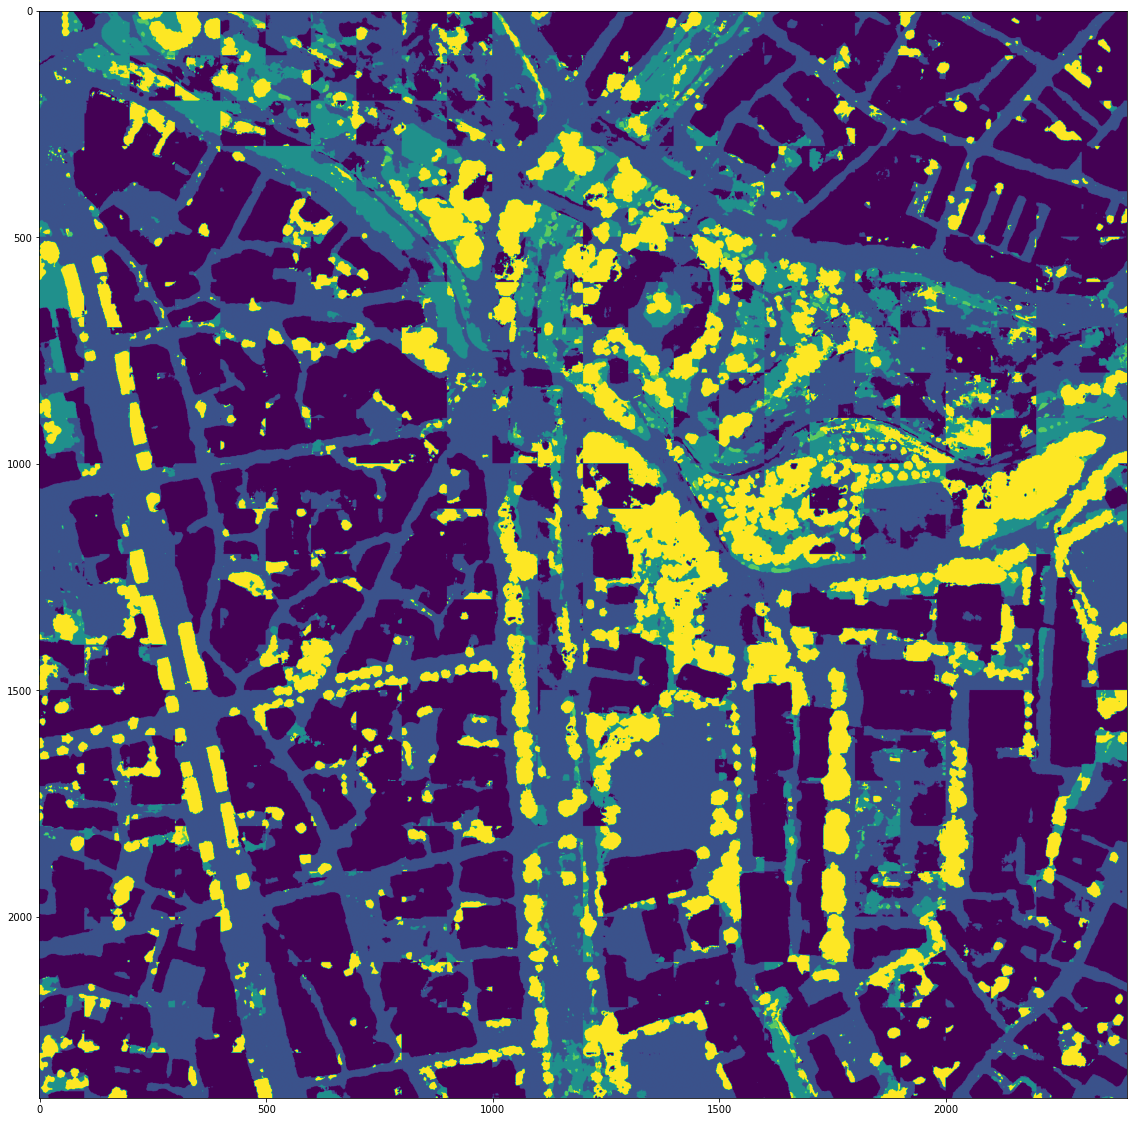

In [12]:
'''for i, (d, _, t, _) in enumerate(N11_prediction_dataloader):
    plt.figure(figsize=(2,2))
    plt.imshow(t[0,:,:])
    plt.figure(figsize=(2,2))
    plt.imshow(F.softmax((model2(d)[0,:,:,:]), dim=0)[-1,:,:].cpu().detach().numpy())
    if i > 10:
        break'''
result_path = legacytraining.save_result2(model2.to(device), dataloader=N11_prediction_dataloader, path=f'/share/project/intern/Byeongchan/Data/Model/Segmentation/{region}', reference_data=reference_data, patch_size=patch_size, device = device, categories=categories)